In [1]:
# This file is an implementation of the Spring Loaded Centroidal Env
# Author : Avadesh Meduri
# Date : 20/06/2020

import numpy as np

import IPython
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from py_motion_planner.sl_cent_motion_planner import SLCentMotionPlanner

In [87]:
'''
This is an implementation of an environment with Spring load Centroidal dynamics to train
dq steper
'''

class SLCentEnv:
    
    def __init__(self, h, b, k, max_step_length, w, no_actions=[11,9]):
        '''
        Input:
            h : height of the com above the ground at the start of the step
            b : width of the base (distance between the feet)
            k : spting stiffness for each leg
            max_step_length : max step length allowed
            w : weights for the cost computation
            no_actions : number of discretizations
        '''
        self.g = 9.81
        self.max_leg_length = 0.32
        self.mass = 1.
        self.inertia = [1, 0.5, 1]
        self.com_offset = 0.078
        # nominal desired height above the foot location
        self.h = h
        self.b = b
        self.no_steps = 0
        assert len(w) == 3
        self.w = w
        assert (np.linalg.norm([max_step_length, self.h - self.com_offset]) < self.max_leg_length)
        assert len(no_actions) == 2
        # The co ordinate axis is x : forward and y : sideways walking, z : faces upward
        # This means that left leg is on the positive side of the y axis
        # The addition b is added to accomodate a step length larger than leg length as it may be feasible
        # in high velocity cases.
        self.action_space_x = np.around(np.linspace(-1.2*max_step_length, 1.2*max_step_length, no_actions[0]), 2)
        # actions to the free side
        if b > 0 :
            self.action_space_ly = np.geomspace(b, 1.5*max_step_length + b, int(2*no_actions[1]/3))
            # actions to the non free side where leg can hit the other leg
            # Y axis actions step length allowed such that robot can't step to the left of the left leg
            # or the right to the right leg (no criss crossing)
            self.action_space_ry = np.linspace(0, b, int(no_actions[1]/3), endpoint = False)
            self.action_space_y = np.around(np.concatenate((self.action_space_ry, self.action_space_ly)), 2)
        else:
            self.action_space_y = np.around(np.linspace(0, max_step_length, int(no_actions[1])), 2)
        
        self.t = 0
        # motion planner params
        self.delta_t = 0.05
        self.f_max = [30,30]
        self.max_ht = [0.4, 0.4]
        self.w = np.array([1e-3, 1e-3, 1e+2, 1e+2, 1, 1, 1e+2, 1e+2])
        self.ter_w = np.array([1e+8, 1e+1, 1e+2, 1e+6, 1, 1])
        assert np.shape(k) == (2,2)
        self.k = k
        self.xt = [0, 0, self.h, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.sl_cent_mp = SLCentMotionPlanner(self.delta_t, 2, self.mass, self.inertia, self.f_max, self.max_ht)
        
    def reset_env(self, x0, v_des, epi_time):
        '''
        This function resets the environment
        Input:
            x0 : starting state [x,y,z,xd,yd,zd]
            v_des : desired velocity of center of mass
            epi_time : episode time
        '''
        assert len(x0) == 6
        self.t = 0
        self.v_des = v_des
        self.sim_data = np.zeros((12 + 3 + 1, int(np.round(epi_time/self.delta_t,2))+1))
        self.sim_data[:,self.t][0:6] = x0
        self.sim_data[:,self.t][13] = -self.b/2
        self.sim_data[:,self.t][15] = 1 # right leg on the ground
        
        processed_state = np.zeros(9)
        processed_state[0:7] = np.take(self.sim_data[:,self.t], [0, 1, 2, 3, 4, 5, 15])
        processed_state[0:3] -= self.sim_data[:,self.t][12:15]
        processed_state[7:] = self.v_des    
        
        return processed_state
    
    def step_env(self, action, step_time, air_time = None, running_gait=True):
        '''
        This function simulates the environment for one foot step
        Input:
            u : next step location
            step_time : duration of after which step is taken [ux_index, uy_index, uz (value)]
        '''
        assert len(action) == 3

        self.xt[2] = self.sim_data[14, self.t] + action[2] + self.h
        if running_gait:
            cnt_plan = [[[0, 0, 0, 0, 0, step_time], [0, 0, 0, 0, 0, step_time]],
                        [[0, 0, 0, 0, step_time, step_time + air_time], [0, 0, 0, 0, step_time, step_time + air_time]]]
        else:
            cnt_plan = [[[0, 0, 0, 0, 0, step_time], [0, 0, 0, 0, 0, step_time]]]
                        
        
        if self.sim_data[:,self.t][15] > 0:
            cnt_plan[0][1][0] = 1
            cnt_plan[0][1][1:4] = self.sim_data[:,self.t][12:15]
                        
        else:
            cnt_plan[0][0][0] = 1
            cnt_plan[0][0][1:4] = self.sim_data[:,self.t][12:15]

            
        k_arr = np.tile(self.k,(int(np.round((step_time+air_time)/self.delta_t, 2)), 1, 1))
    
        
        time_steps = int(np.round((step_time+air_time)/self.delta_t, 2))
        self.sim_data[0:12, self.t:self.t+time_steps+1], u_arr = \
                self.sl_cent_mp.optimize(self.sim_data[0:12, self.t], cnt_plan, k_arr , self.xt, self.w, self.ter_w, step_time + air_time)
        
        self.sim_data[12:, self.t:self.t + time_steps+1] = np.tile([self.sim_data[:,self.t][12:]],(time_steps+1,1)).T #u
        self.t += time_steps
        self.sim_data[12, self.t] += self.action_space_x[action[0]]
        self.sim_data[13, self.t] += self.sim_data[15, self.t]*self.action_space_y[action[1]]
        self.sim_data[14, self.t] += action[2]
        self.sim_data[15, self.t] = -1*self.sim_data[15, self.t]
        
        if running_gait:
            self.sim_data[15,self.t-int(np.round(air_time/self.delta_t,2)):self.t] = 0 
            
        processed_state = np.zeros(9)
        processed_state[0:7] = np.take(self.sim_data[:,self.t], [0, 1, 2, 3, 4, 5, 15])
        processed_state[0:3] -= self.sim_data[:,self.t][12:15]
        processed_state[7:] = self.v_des    
        
        if self.isdone(processed_state):
            self.sim_data = self.sim_data[:,0:self.t]
            
        return processed_state, self.isdone(processed_state)
    
    def isdone(self, processed_state):
        '''
        This function checks if the kinematic constraints are violated
        '''
        leg_dist = processed_state[0:3].copy()
        leg_dist[2] -= self.com_offset
        if np.linalg.norm(leg_dist) > self.max_leg_length:
            return True
        else:
            return False
    
    
    def show_episode(self, freq):
        '''
        Shows animation
        Input :
            freq : frame rate
        '''
        sim_data = np.array([self.sim_data[:,0]]).T
        
        for t in range(len(self.sim_data[0])-1):
            tmp = np.linspace(self.sim_data[:,t], self.sim_data[:,t+1], 10).T
            sim_data = np.concatenate((sim_data, tmp), axis=1)
        
        sim_data = sim_data[:,::freq]
        
        fig = plt.figure()
        ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
        text_str = "top view of IPM"
        base, = ax.plot([], [], lw=3, color = 'blue')
        leg, = ax.plot([], [], lw=3, color = 'pink')
        com, = ax.plot([], [], 'o', color='red')
        foot, = ax.plot([], [], 'o', color='green')

        
        def init():
            base.set_data([], [])
            leg.set_data([], [])
            com.set_data([], [])
            foot.set_data([], [])
            return base, leg, com, foot
        
        def animate(i):
            x = sim_data[:,i][0]
            y = sim_data[:,i][1]
            if sim_data[:,i][15] == 1 or sim_data[:,i][15] == -1:
                ux = sim_data[:,i][12]
                uy = sim_data[:,i][14]
            else:
                ux = x
                uy = y
            
            if sim_data[:,i][15] > 0:
                n = 1
            else:
                n = -1
            
            base.set_data([x, x], [y - self.b/2, y + self.b/2])
            leg.set_data([x, ux], [y - n*(self.b/2), uy])
            com.set_data([x], [y])
            foot.set_data([ux], [uy])
            return base,leg, com, foot
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)
        plt.grid()
        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))
    
    def show_episode_side(self, freq):
        '''
        shows animation from the side view
        Input:
            freq : frame rate
        '''

        sim_data = np.array([self.sim_data[:,0]]).T
        
        for t in range(len(self.sim_data[0])-1):
            tmp = np.linspace(self.sim_data[:,t], self.sim_data[:,t+1], 10).T
            sim_data = np.concatenate((sim_data, tmp), axis=1)
        
        sim_data = sim_data[:,::freq]
        
        fig = plt.figure()
        ax = plt.axes(xlim=(-2, 2), ylim=(-0.2, 0.5))
        text_str = "side view (xz plane)"
        leg, = ax.plot([], [], lw=4)
        body, = ax.plot([], [], lw=4)
        head, = ax.plot([], [], 'o', color='green')
        com, = ax.plot([], [], 'o', color='red')
        foot, = ax.plot([], [], 'o', color='pink')
        
        def init():
            leg.set_data([], [])
            body.set_data([], [])
            head.set_data([], [])
            com.set_data([], [])
            foot.set_data([], [])
            
            return leg, body, head, com, foot
        
        def animate(i):
            x = sim_data[:,i][0]
            y = sim_data[:,i][2]
            
            if sim_data[:,i][15] == 1 or sim_data[:,i][15] == -1:
                ux = sim_data[:,i][12]
                uy = sim_data[:,i][14]
            else:
                ux = x
                uy = y - self.com_offset
            
            leg.set_data([ux,x], [uy,y - self.com_offset])
            com.set_data([x, y])
            body.set_data([x, x], [y, y - self.com_offset])
            head.set_data([x, y])
            foot.set_data([ux, uy])

            return leg, com, body, head, foot
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)

        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))
    

In [88]:
ht = 0.28
k = [[10, 0], [10, 0]]
step_time = 0.2
air_time = 0.2
no_steps = 10


env = SLCentEnv(ht, 0.13, k, 0.22, [0, 1, 0], [11,9])
state = env.reset_env([0, 0, ht, 0.0, 0, 0], [0, 0], no_steps*(step_time + air_time))

for n in range(no_steps):
    action = [5, 3, 0.0]
    next_state, isdone = env.step_env(action, step_time, air_time, running_gait = True)
#     print(next_state)
    state = next_state
    if isdone:
        break
    
# env.show_episode(3)
env.show_episode_side(3)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABMmm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA6iZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB4He8+Ufc6GICcqXgiFx7hrCoEqYZB7KDd
8okGGWxSWca1KYuDuU4W1eJxcEXyOT5GNRIQsAAAKfHbex8Hr+aYxodae7yrV900HOfa4hGvFN7d
dlVdeAl9U8eiA6xlrhN9gzZqV0I2t8zNTaXodi70S4BQZNvZZlCWB8fiMqFMFelUO3ZxzKJEAa5i
aY4M6fwnX7GhA35uWr4L6ferBsLX5QAi6sfCS8NA9Q1vFFprJVyeRb08p6yVyrZcdqIj3DW2T2FM
DaA5XSZVMbovSf2MOKR5Q2aJkKqSw7qWXXd+dGehm/5kQPNUpVc6FqCW0SlkKrckR+ifT+fqKw0Z
HLWVmlMGjdr2y9ZVTQLs2tW3LBuvxuVcjrB8V7Aan4Xmv8LXqSg4PgY7bNBOZPSaKcBkOKbSLjyn
bc83IOMR2KjySU4dVPYx0bGtPtYx5NZzoL/GhPJWDTYqYAT4czgxkCz8t8hfNH6pN4NUoR/Gq5sT
RwSF/JTVETs0DoaB1qOepM/sha3SfSaYTWaOvFu/xk6mWGUaIglyAVo59str2hJ2PymXDMCAt7wh
W6PUBIuEXZ+5kCO6N5u0LmYBhe+9YFMjqh0ZACEi39GQtfC/9iJeqxHyzdJlaSdbLCavTiVvFYsV
C33ReP+dj0eXoLFrTt5RbEpYvtmnyk6Y6lMJRCp1xBhrhTu96vyL1//jXftgmBTHmNqPWd2HMAS7
riquoSsvUDObrXICodDP9exVbbmZ/8CZuwMz56GP5Fdf+V1BRmGoBET9mH+85xAlvmCo90IpefjM
F/j9OSFNycGFEKhFyRLnK+Wzxlajv6Egq3oUs1uS54eGw/ZrYCFlWm8BVHklVEgmndTAknOue7u1
UicZF55mmDncHUSYn1t5N8I8aVxrfsEA1w77M8K938SOisWfxZeFL2Yl5GD6RgDgmgdD9OlU2Y+9
/55WAASS1XCAO3iJs+YTlORGM6V/hlDOkYkPtF7yACNWB2G17xGO+VHM/Ea9xOd1oWnXwz/FF3qL
mL8m7oDel1CsRdXavJAFrYEpS/syPFR++VlgLcrGek8QnkamxdMwVe2XhlCHtrrK3w8sK8/NYsat
ue4/5V3/R1ZbpqcTEFhmaA2IGIeQZpYrvgY0slJG7D0YV7WaYx9lQ6ChA/2dGThJ7xqwsra/gfZ+
oSrTLX/T6mJ2diEtjF9AfoBuMy63o3iT8yYtxvobkmyzqoL4RGg8o6ePGlH7Gh3brGj4x3kSIS1n
A3ZgRHACMCVFGPaWpwYfCoDqq+SCI/upZ7duLVEF/FPARj6hHlC4Qsz2NpiX376L2XeaZ5kBFuJT
ZvUf9B8WK0wV6WZa3sGWJexrKCZOH0k1Qm+CXBOzHv6tZ1FKaFCZaFEQsfnAK5KV9KqvzDmFAPzi
Us5bGA1+S+hk4+GcgTBNh9GvtSs43kd5XLhHBzro9YxIA/QDZvxOjYeaE5JiVZ1Yt6U88uFPIQ5f
PhJsqGUuqMRbbrLFEAbeNhNG/mPtF56aPeBi2kUsOAlwp2ay5tnFlh5rAD6qmQLQ4wia3TGvwcgJ
T486CBJu/2qlHk+nJ/L5m23OD38dI6DhyQu11MudFOcc2ye5ko+s5+w0iegR14IFZeYA7rRnvGG0
KZlUZjUuNz50vgWx6RQAJInMrJow3KsE2BYcGn6zH0btfG5nBPj0bsc7VFmr51krF2iqGXvOVPHt
ryD+tOPRlEbkSCp+IWTviTdHNHM52v8AhkgcOtdsqu/XoYsJFqj2vgXWo6LP0pXLYvAm+HrrIZY1
MJf2LfRkfKZvThwlcniBUr2DyjWbYDhT7rQc+le3m+Y4EAsq7oFng/5q62PSHnlEXd+uyBnCkmrT
GPpi25w9DerLv/Vffqqgx+Ajhsue7PGcMljBmbSuKJ9cuwekWqQBcQDpadGjylagraf7VnGHeBvs
PHB2heCpRPjZ+M++q8WjwKhRzJjKPdjbtn/XM24Pzvv9qB3mw5CFDzlP5p2w/AdfyBJkcSvWUNs/
Q2FxzQ/+lQ9IhfZ3LMNzUaBnIusH6QAw61jSFfz9J/5jnERB+rrgHGfKww14srwXYmeVXv14Whbi
HWU4UiWnaL1GtOiaaVUHAxN2A9eKjLc3sta62pZz4e6UcB1/Be8DJ4HuwrBAE6buVZ206cXfcp2A
3QDrMwSgXUGjgwEIxpbQbI7xtm7lPiL8p16jpb2Ky/kWKVV3NS0O+eZTc6U/gBAhmCT2gbkrcfaW
DmV/PKFTXrDOQ4+ssvs/OSPFEH1D1OK72Bulr692XsFrM9hYo7NZDPCDJsMkg2quHXQqZYO7tFDv
WfBtI2XSJ5T0/LgAxsB1XK+R53SHChRQZeoInLJD3hGl+gKAM6yh5SN6Ezq202wMDULglVrZSb1T
X5Us9hN7nP7sXOhmklVBXrO5ukm57xcLjincmlRpPETFuhYPwER4W5NbH+08ahz5Ss9WUK5XgL02
TEgzannlq7aaWyx8G/mFivwkgaozLmLvCUw2iFQXO9FTvo7Hq9Gemty8z2GVFcOkc7FiBDjjnAYI
DdJYXc5+c/MLT1Fz98HTB8fw/9J8n8UAPGdCMnB2OldBgDdL0cc/wum/YYtTcF8j3JVYLacYl7+x
f7hyCtjQrn7O0sn8e2WT+sZ9+V99x+y07TKILirsi+BNsg70Z2+VStJX0Y8SjKEnAdsQVjINWTuN
xvqIva7uwjY3UXUAnr6Y+4f1II5DmgGumI+X6Xj2pQzVd6whJfrbFlcrOcHwsokosAZ2lWYgyI8j
Qjzqfksm2g0RZXBaiX4qNQHLYz4SOm7nEtmVh2aTdiIXIFrejAb9tNz8VJ0Gv+S4lsudv5afTTBE
0O8ZFtneGILjkjs0kIL9M

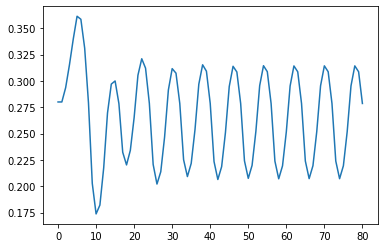

In [90]:
plt.plot(env.sim_data[2])

# plt.plot((180/np.pi)*env.sim_data[6])
